In [2]:
import pandas as pd
import numpy as np
import nltk
from tqdm.notebook import tqdm

In [2]:
dtypes = {
    'Username' : str,
    'Tweet': str,
    'Reply to': str,
    'Participants' : object,
    'Hashtags': object,
    'Date': str,
    'nLikes': int,	
    'nReplies': int,	
    'nRetweets': int,
    'Emotion': str, 
    'Polarity': str
}

In [3]:
df = pd.read_json('data/brokenmirror-sentiment.json', dtype=dtypes)

In [4]:
df.head()

,Username,Tweet,Reply to,Participants,Hashtags,Date,nLikes,nReplies,nRetweets,Emotion,Polarity
0,C,A partire da oggi scattano alcune novità che m...,None,None,[],2020-07-01 19:20:21,2153,955,333,sadness,pos
1,C,Complimenti alla nostra @GDF per la maxi-opera...,None,None,[],2020-07-01 13:38:24,3577,317,472,fear,neg
2,C,Un bimbo per strada mi ha chiesto se riuscirò ...,None,None,[],2020-07-02 17:58:18,7711,2104,974,sadness,pos
3,C,Una icona italiana abbraccia la transizione en...,None,None,[fiat500],2020-07-03 18:41:38,3382,422,441,joy,pos
4,C,Our hearts and minds today are more than ever ...,None,None,[independenceday],2020-07-04 17:58:48,3015,444,316,joy,pos


#### Functions to save and load MGP models

In [24]:
import os
import pickle
def save_mgp(mgp, version, directory='models'):
    if not os.path.isdir(directory):
        os.mkdir(directory)
        print(f"Directory {directory} created")
    k = str(mgp.K).replace(".","")
    alpha = str(mgp.alpha).replace(".","")
    beta = str(mgp.beta).replace(".","")
    n_iters = mgp.n_iters
    
    filename = f'{directory}/K{k}a{alpha}b{beta}i{n_iters}-{version}.model' 
    if not os.path.isfile(filename):
        with open(filename, 'wb') as file:
            pickle.dump(mgp, file)
        print('Model saved:', filename)
    else:
        print('File already exists:', filename)
def load_mgp(filename):
    if os.path.isfile(filename):
        mgp = ''
        with open(filename, 'rb') as file:
            mgp = pickle.load(file)
        print('Model loaded:', filename)
        return mgp
    else:
        print('File does not exist:', filename)


#### Functions for MGP models

In [6]:
from gsdmm.gsdmm import MovieGroupProcess

def top_words(cluster_word_distribution, top_cluster, values):
    '''prints the top words in each cluster'''
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — —')
        
def model_info(mgp):
    """prints info about the model"""
    doc_count = np.array(mgp.cluster_doc_count)
    print('Number of documents per topic :', doc_count)
    print('*'*20)
    # topics sorted by the number of documents they are allocated to
    top_index = doc_count.argsort()[-10:][::-1]
    print('Most important clusters (by number of docs inside):',   
           top_index)
    print('*'*20)
    # show the top 5 words in term frequency for each cluster 
    topic_indices = np.arange(start=0, stop=len(doc_count), step=1)
    top_words(mgp.cluster_word_distribution, topic_indices, 10)

def set_topic_names(topic_names, topic_indices):
    """returns a dict topiv_index : topic_name"""
    topic_dict = {}
    for i, topic_num in enumerate(topic_indices):
         topic_dict[topic_num]=topic_names[i]
    return topic_dict

#### Tweet preprocessing

In [36]:
#pip install pretwita
from pretwita import PreTwITA as PTW
def tokenize_and_clean(tweet):
    sw = ['\u2066\u2069', 'lega', 'italiani'] 
    ptw = PTW(tweet).clean(placeholder=False, 
                           additional_stopwords=sw, 
                           keep_dates=False)
    return ptw.get_tokens()

In [37]:
df['Tokens'] = df.Tweet.apply(tokenize_and_clean)

#### MGP model

In [41]:
params = {
    "K":10, # number of topics
    "alpha":0.1, # completeness
    "beta":0.1, # homogeneity
    "n_iters":20 # number of tranfers
}

In [42]:
mgp = MovieGroupProcess(**params)
vocab = set(word for tweet in df.Tokens for word in tweet)
n_terms = len(vocab)
y = mgp.fit(df.Tokens, n_terms)


In stage 0: transferred 7654 clusters with 10 clusters populated
In stage 1: transferred 4594 clusters with 10 clusters populated
In stage 2: transferred 3098 clusters with 10 clusters populated
In stage 3: transferred 2261 clusters with 10 clusters populated
In stage 4: transferred 1820 clusters with 10 clusters populated
In stage 5: transferred 1517 clusters with 10 clusters populated
In stage 6: transferred 1294 clusters with 10 clusters populated
In stage 7: transferred 1155 clusters with 10 clusters populated
In stage 8: transferred 1083 clusters with 10 clusters populated
In stage 9: transferred 1073 clusters with 10 clusters populated
In stage 10: transferred 1072 clusters with 10 clusters populated
In stage 11: transferred 1047 clusters with 10 clusters populated
In stage 12: transferred 1014 clusters with 10 clusters populated
In stage 13: transferred 951 clusters with 10 clusters populated
In stage 14: transferred 1001 clusters with 10 clusters populated
In stage 15: transfer

In [43]:
model_info(mgp)

Number of documents per topic : [1225 1126 1309 2029  127  933  612  640 1477  210]
********************
Most important clusters (by number of docs inside): [3 8 2 0 1 5 7 6 9 4]
********************
Cluster 0 : [('anni', 219), ('oggi', 153), ('grazie', 146), ('vita', 146), ('grande', 123), ('sempre', 112), ('🇮🇹', 104), ('️', 94), ('abbraccio', 88), ('stato', 88)]
 — — — — — — — — —
Cluster 1 : [('governo', 220), ('scuola', 140), ('ministro', 136), ('azzolina', 127), ('banchi', 100), ('oggi', 87), ('milioni', 82), ('insegnanti', 81), ('scuole', 81), ('studenti', 78)]
 — — — — — — — — —
Cluster 2 : [('governo', 393), ('clandestini', 211), ('sbarchi', 206), ('immigrati', 146), ('porti', 135), ('ministro', 131), ('confini', 120), ('paese', 119), ('italia', 118), ('sicurezza', 115)]
 — — — — — — — — —
Cluster 3 : [('governo', 647), ('lavoro', 225), ('conte', 185), ('tasse', 165), ('imprese', 164), ('italiani', 158), ('oggi', 150), ('milioni', 147), ('senza', 138), ('paese', 134)]
 — — — — 

In [44]:
save_mgp(mgp, 0)

Model saved: models/K10a01b01i20-0.model


In [137]:
topic_names = [
    "Solidarietà",
    "Scuola",
    "Porti, confini e immigrazione",
    "Lavoro, tasse e imprese",
    "Tweet in Francese",
    "UE",
    "Rumore",
    "Politica e istituzioni",
    "Comizi, dirette social, interventi TV",
    "Tweet in Inglese",
]
doc_count = np.array(mgp.cluster_doc_count)
topic_indices = np.arange(start=0, stop=len(doc_count), step=1)
topic_dict = set_topic_names(topic_names, topic_indices)

In [138]:
topic_dict

{0: 'Solidarietà',
 1: 'Scuola',
 2: 'Porti, confini e immigrazione',
 3: 'Lavoro, tasse e imprese',
 4: 'Tweet in Francese',
 5: 'UE',
 6: 'Rumore',
 7: 'Politica e istituzioni',
 8: 'Comizi, dirette social, interventi TV',
 9: 'Tweet in Inglese'}

In [139]:
def get_topic(doc, topic_dict=topic_dict):
    """returns topic"""
    topic, score = mgp.choose_best_label(doc)
    return topic_dict[int(topic)]
df['Topic'] = df['Tokens'].map(get_topic)

In [186]:
# 999 'Politica e istituzioni'
# 8390 503 'Solidarietà'
# 225 'Lavoro, tasse e imprese'
# 504 'Tweet in Francese'
# 505 'Scuola'
# 537 'Tweet in Inglese'
# 7015 ' Comizi, dirette social, interventi TV'
x=7000
print(x)
for x in range(x, x+30):
    print(df.Tweet[x],'\n', df.Topic[x], '\n',x)
    print()
    

7000
Fino a quando rimarrà il "signor" Morra, personaggio arrogante che ha infangato la memoria di Jole Santelli e insultato milioni di malati e le loro famiglie, i parlamentari di Lega e centrodestra non parteciperanno ai lavori della Commissione antimafia. #Morradimettiti 
 Scuola 
 7000

Tra poco, verso le 8.35, mi collego con @RadioCapital_fm.  Buona settimana, Amici 👋🏻  https://t.co/sfJR2LA1ck 
 Comizi, dirette social, interventi TV 
 7001

@BrunoVespa: "Ristori? Perché non abbiamo copiato la Germania? Hanno dato il 75% del fatturato perso. Il fatto che in Italia ci siano categorie dimenticate è imbarazzante".  #vociitaliane  https://t.co/zw7O8k3Y2I 
 Lavoro, tasse e imprese 
 7002

#Salvini: Lo chiedo al ministro Azzolina: invece di andare a comprare i banchi con le rotelle si occupasse di stabilizzare insegnanti di sostegno precari, perché quando si tornerà a scuola non ci siano bimbi dimenticati. #MaurizioCostanzoShow 
 Scuola 
 7003

#Salvini: Chiedo al governo di convocare i 

In [188]:
df.to_json('data/brokenmirror-def.json')

In [5]:
df = pd.read_json('data/brokenmirror-def.json')

In [67]:
topic_count = df.groupby(['Username','Topic']).size().to_frame(name='count').reset_index()
C_n = len(df[df['Username'] == 'C'])
L_n = len(df[df['Username'] == 'L'])
S_n = len(df[df['Username'] == 'S'])
M_n = len(df[df['Username'] == 'M'])


In [80]:
def func(count,condition):
    div = dict(zip(['C', 'L', 'S', 'M'], [C_n,L_n,S_n,M_n]))
    return count / div[condition]

topic_count['perc'] = topic_count.apply(lambda x: func(x['count'], x['Username']), axis=1)

In [421]:
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('tab20c')
colors = []
for i in range(cmap.N):
    rgb = cmap(i)
    colors.append(rgb)

labels = df.Topic.unique()
colordict = dict(zip(labels, colors))

In [364]:

def topic_chart(username):
    u = username[0].upper()
    # Data to plot
    # Take the information from the segment and label columns and join them into one string
    labels = topic_count[topic_count['Username'] == u][['Topic', 'perc']]['Topic']
    # Extract the sizes of the segments
    sizes = topic_count[topic_count['Username'] == u][['Topic', 'perc']]['perc']
    # Plot with labels and percentage
    plt.title(f'Topic distribution – {username}')
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', pctdistance=0.6)
    centre_circle = plt.Circle((0,0),0.65,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.savefig(f'plots/topic-{username}.png')
    plt.show()

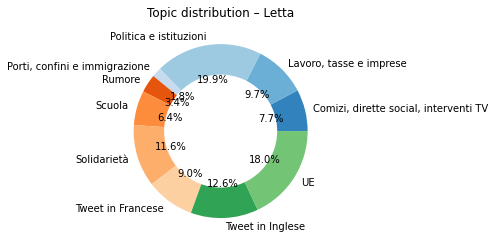

In [365]:
topic_chart('Letta')

In [345]:
import datetime
def get_timerange(date, delta):
    date = pd.to_datetime(date)
    start_date = date - datetime.timedelta(days=delta)
    end_date = date + datetime.timedelta(days=delta)
    return (start_date, date), (date, end_date)

In [424]:

def chart_with_date(date, username, delta=7):
    dates = get_timerange(date, delta)
    
    df1 = df[(df['Date'] >= dates[0][0]) & (df['Date'] <= dates[0][1])]
    df2 = df[(df['Date'] >= dates[1][0]) & (df['Date'] <= dates[1][1])]
    topic_count1 = df1.groupby(['Username','Topic']).size().to_frame(name='count').reset_index()
    C_n = len(df1[df1['Username'] == 'C'])
    L_n = len(df1[df1['Username'] == 'L'])
    S_n = len(df1[df1['Username'] == 'S'])
    M_n = len(df1[df1['Username'] == 'M'])
    f = lambda x,y: x / dict(zip(['C', 'L', 'S', 'M'], [C_n,L_n,S_n,M_n]))[y]
    topic_count1['perc'] = topic_count1.apply(lambda x: f(x['count'], x['Username']), axis=1)
    
    topic_count2 = df2.groupby(['Username','Topic']).size().to_frame(name='count').reset_index()
    C_n = len(df2[df2['Username'] == 'C'])
    L_n = len(df2[df2['Username'] == 'L'])
    S_n = len(df2[df2['Username'] == 'S'])
    M_n = len(df2[df2['Username'] == 'M'])
    f = lambda x,y: x / dict(zip(['C', 'L', 'S', 'M'], [C_n,L_n,S_n,M_n]))[y]
    topic_count2['perc'] = topic_count2.apply(lambda x: f(x['count'], x['Username']), axis=1)
    
    u = username[0].upper()
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 12))
    plt.suptitle(f'{username} – {date} — delta:{delta}')
    
    cmap = cm.get_cmap('tab20c')
    colors = []
    for i in range(cmap.N):
        rgb = cmap(i)
        colors.append(rgb)
    
    labels = df.Topic.unique()
    colordict = dict(zip(labels, colors))
    
    
    sizes = topic_count1[topic_count1['Username'] == u][['Topic', 'perc']]['perc']

    axs[0].pie(sizes, colors=[colordict[key] for key in labels], autopct='%1.1f%%', pctdistance=0.6)
    axs[0].set_title('Before')
    
    sizes = topic_count2[topic_count2['Username'] == u][['Topic', 'perc']]['perc']
    axs[1].pie(sizes, colors=[colordict[key] for key in labels], autopct='%1.1f%%', pctdistance=0.6)
    axs[1].set_title('After')

    
    
    fig.tight_layout()
        
    for k, v in colordict.items():
        if k in set(list(topic_count1[topic_count1['Username'] == u]['Topic']) + list(topic_count2[topic_count2['Username'] == u]['Topic'])):
            axs[1].scatter([],[], color=v, label=k)
            axs[1].legend(loc='upper right')
    plt.savefig(f'plots/{username}_{date}_{delta}.png')
    plt.show()
    

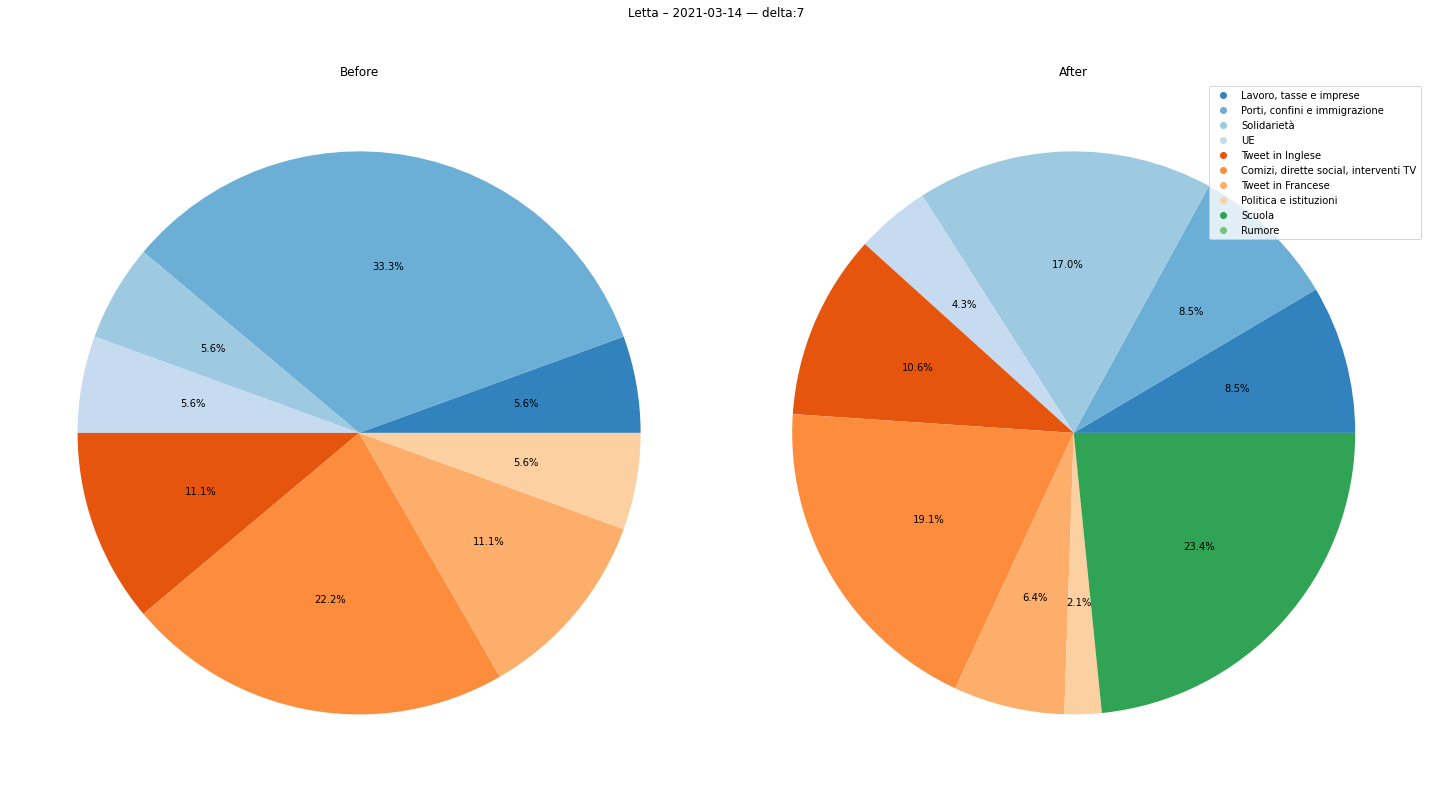

<ipython-input-424-3584d356f73d>:39: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  axs[0].pie(sizes, colors=[colordict[key] for key in labels], autopct='%1.1f%%', pctdistance=0.6)


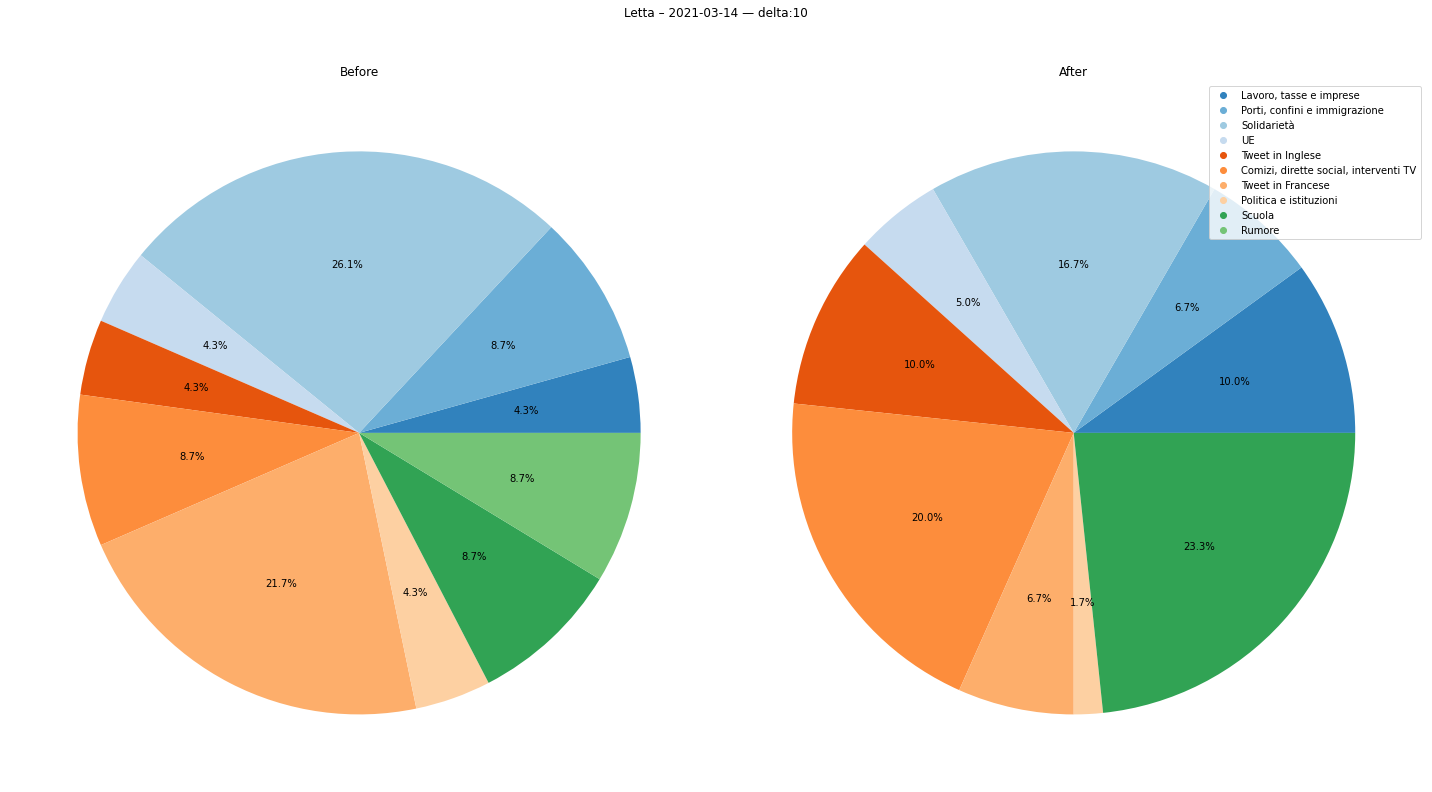

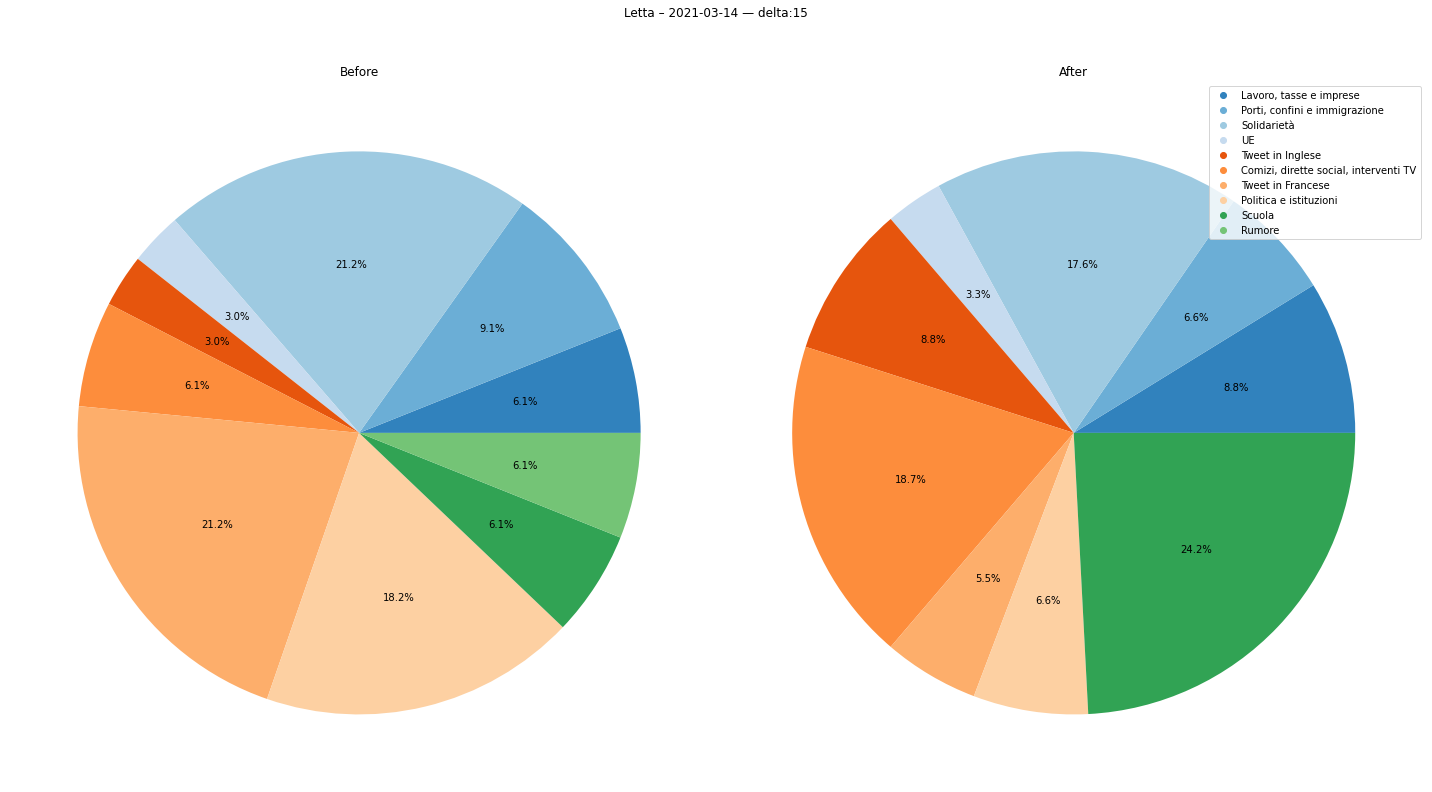

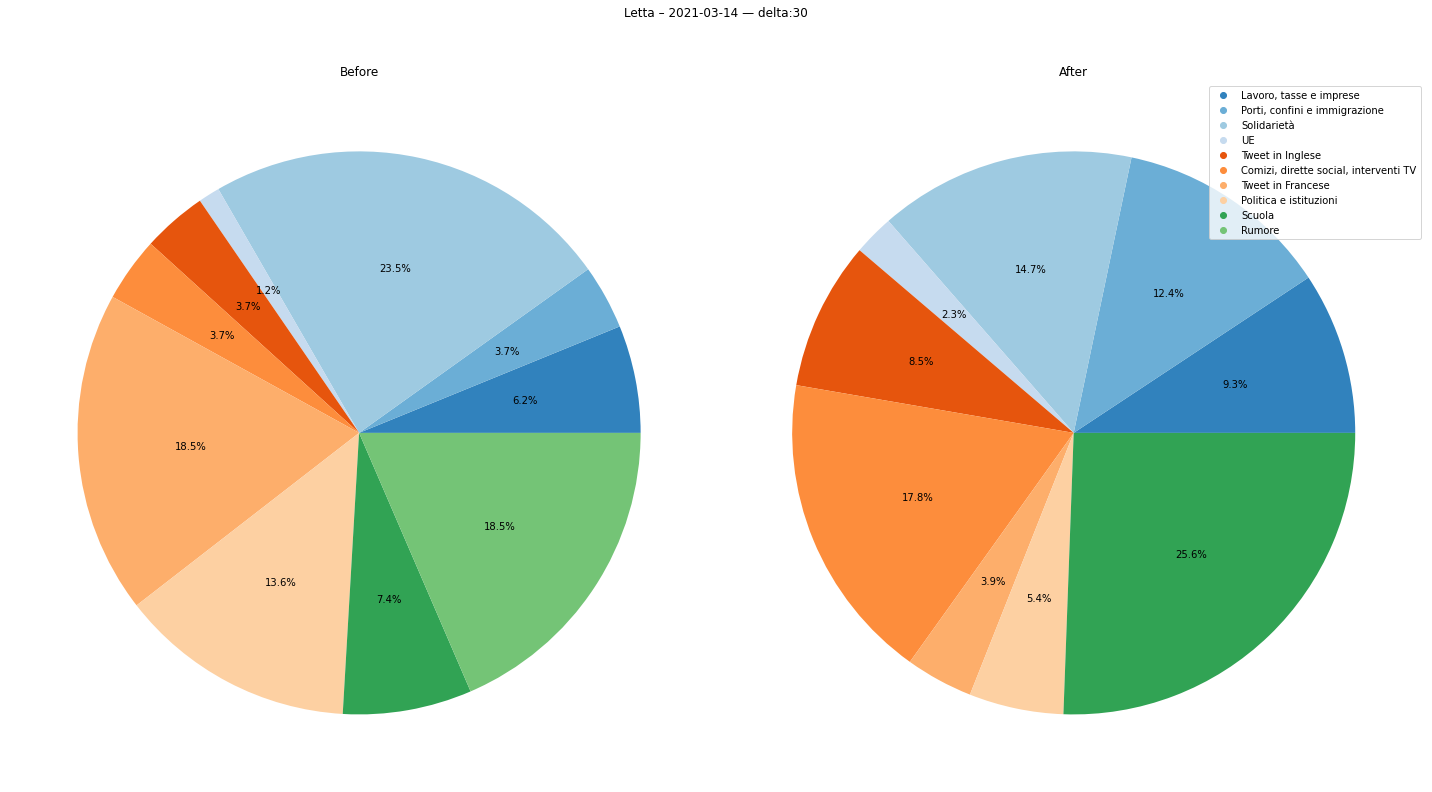

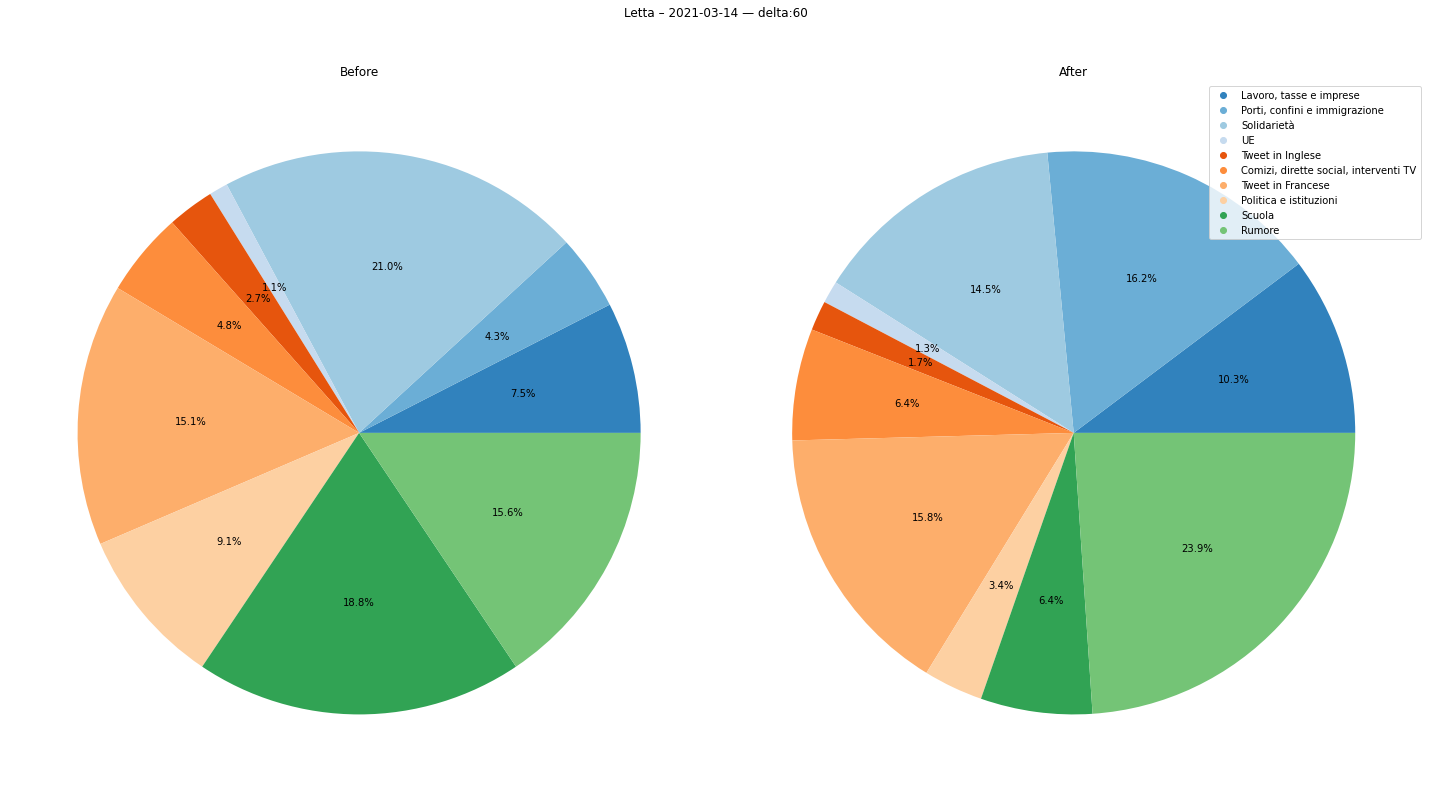

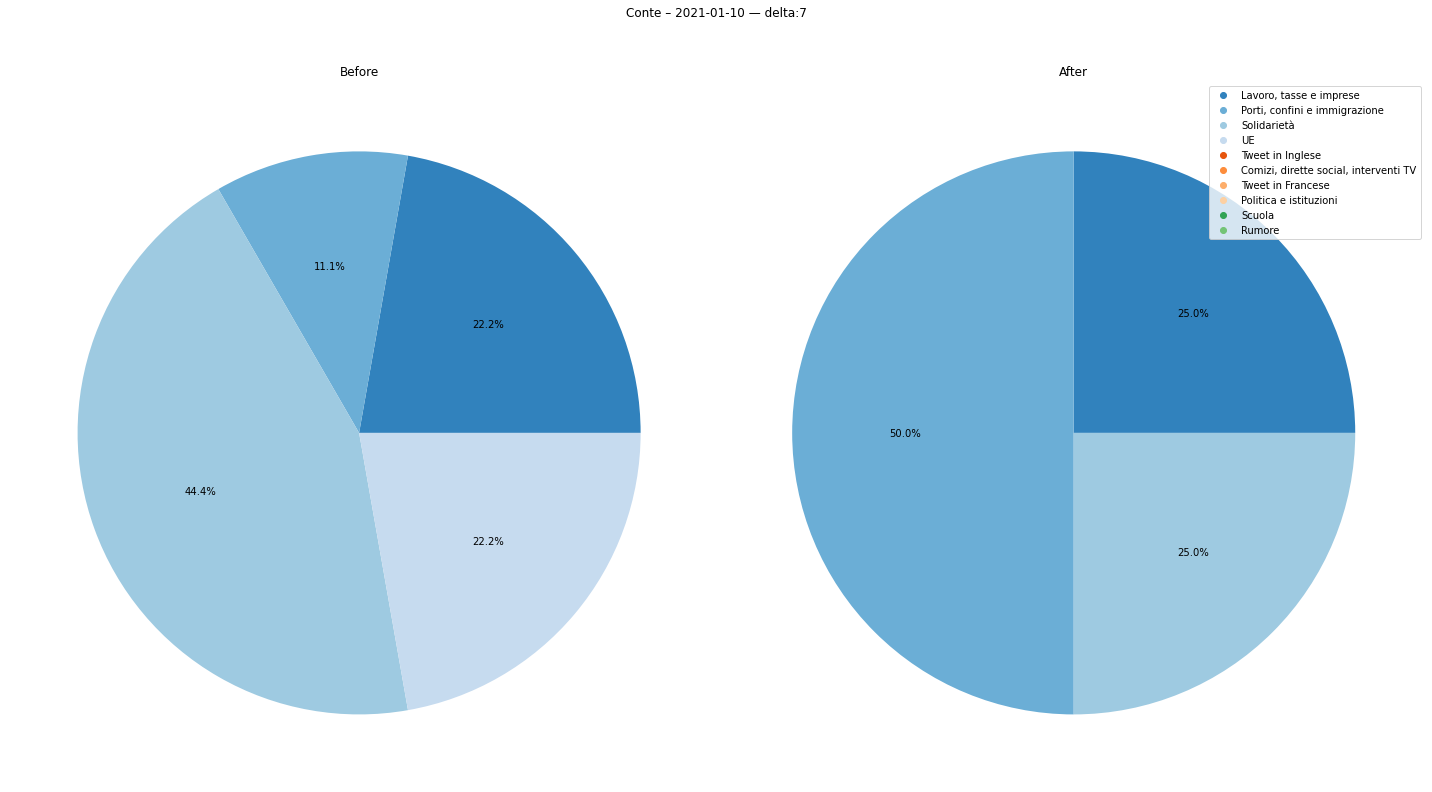

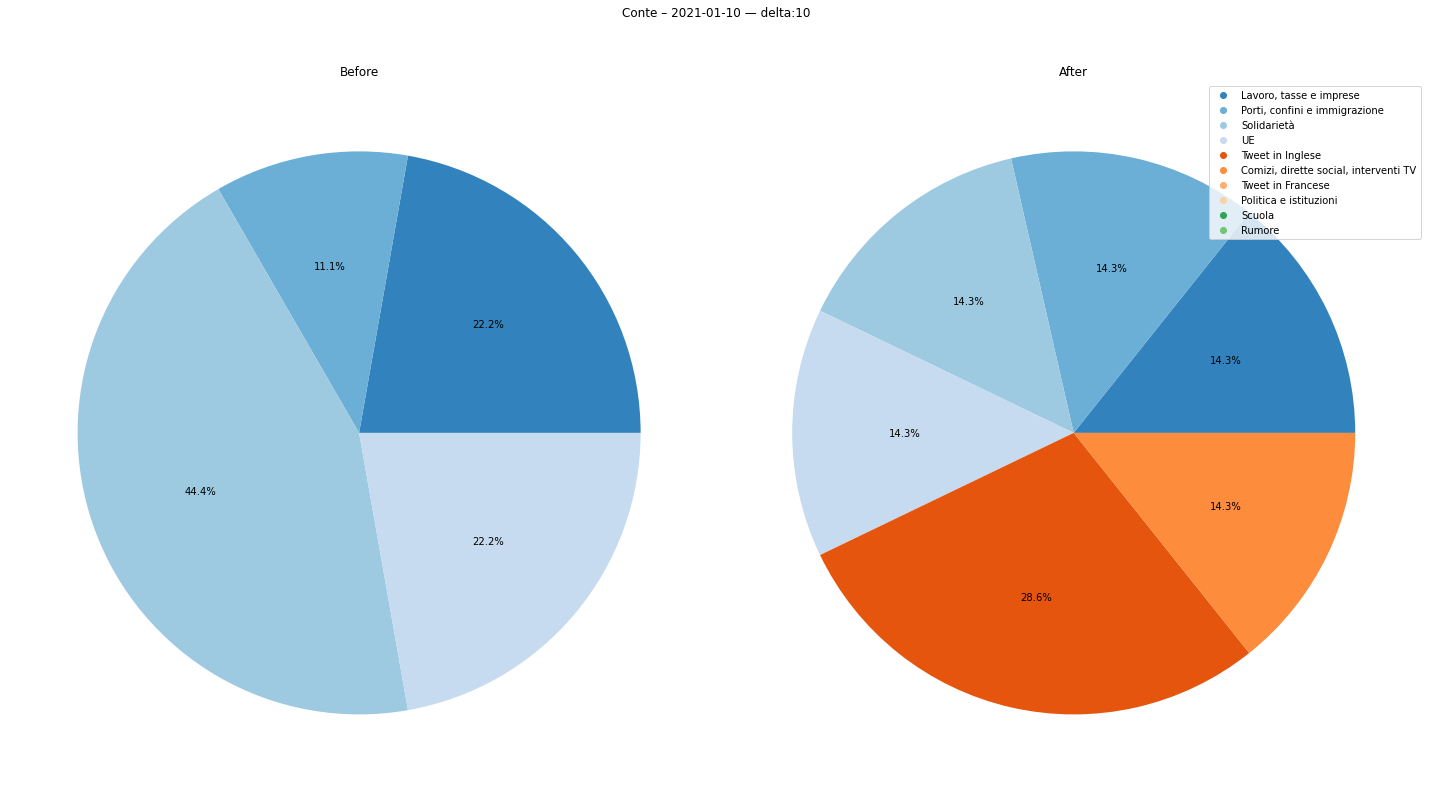

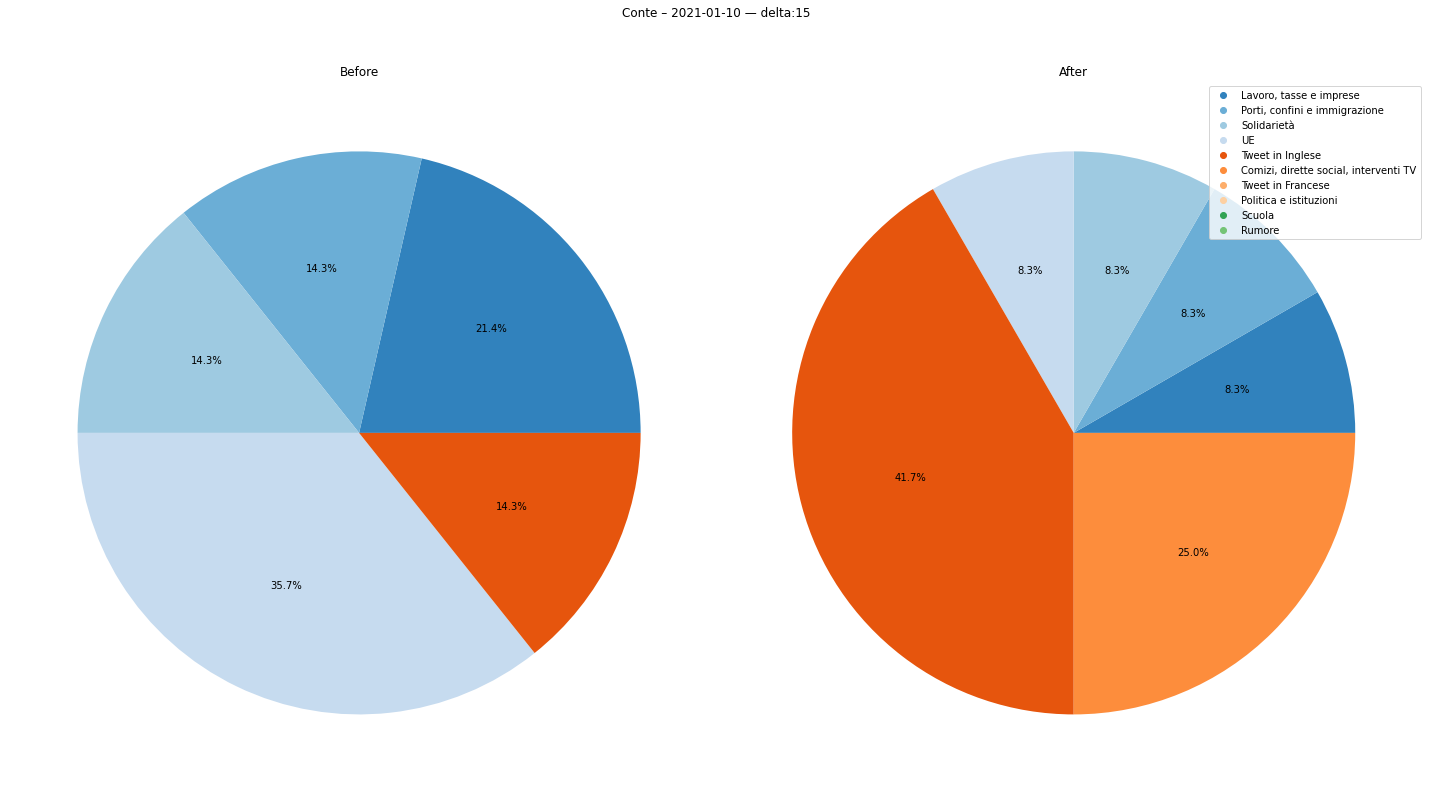

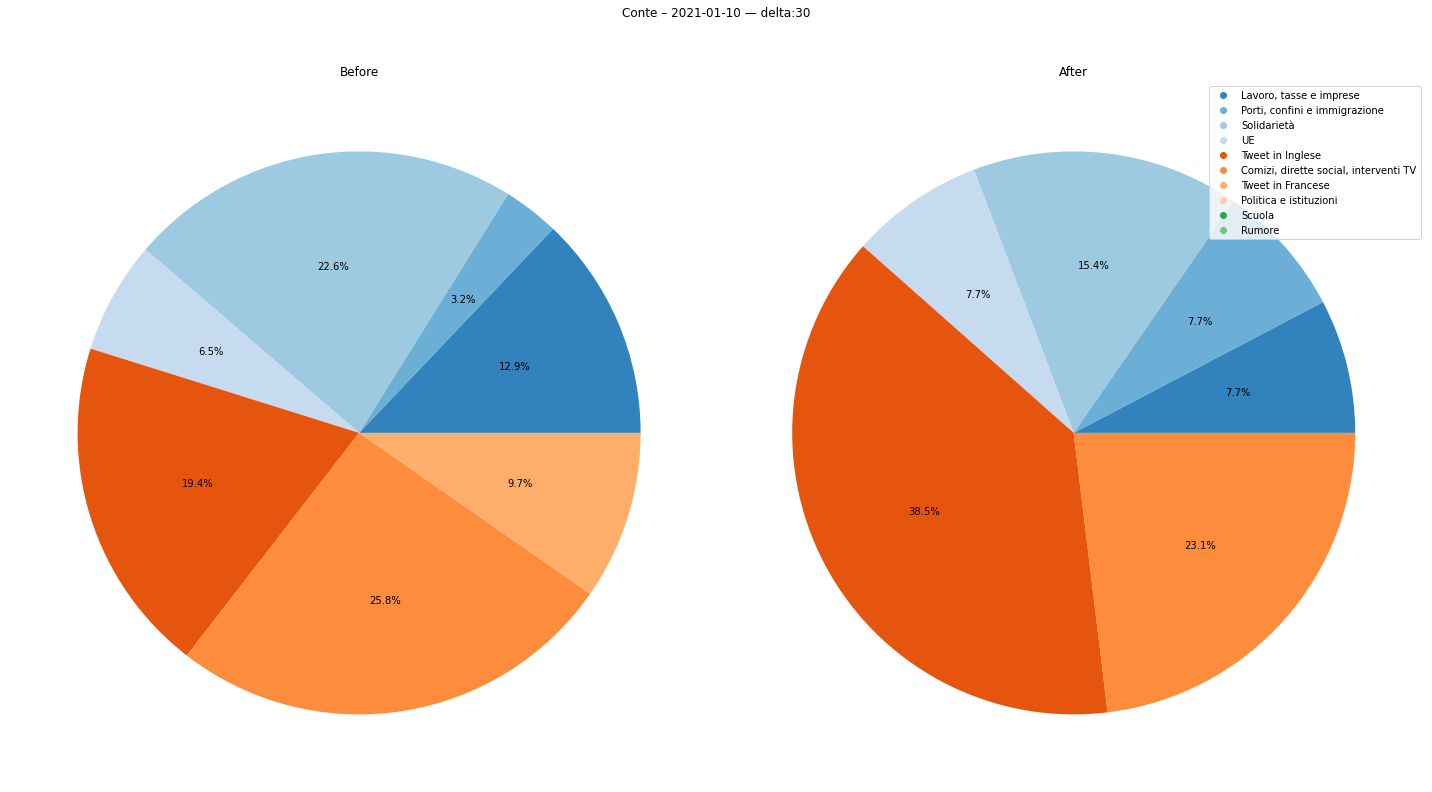

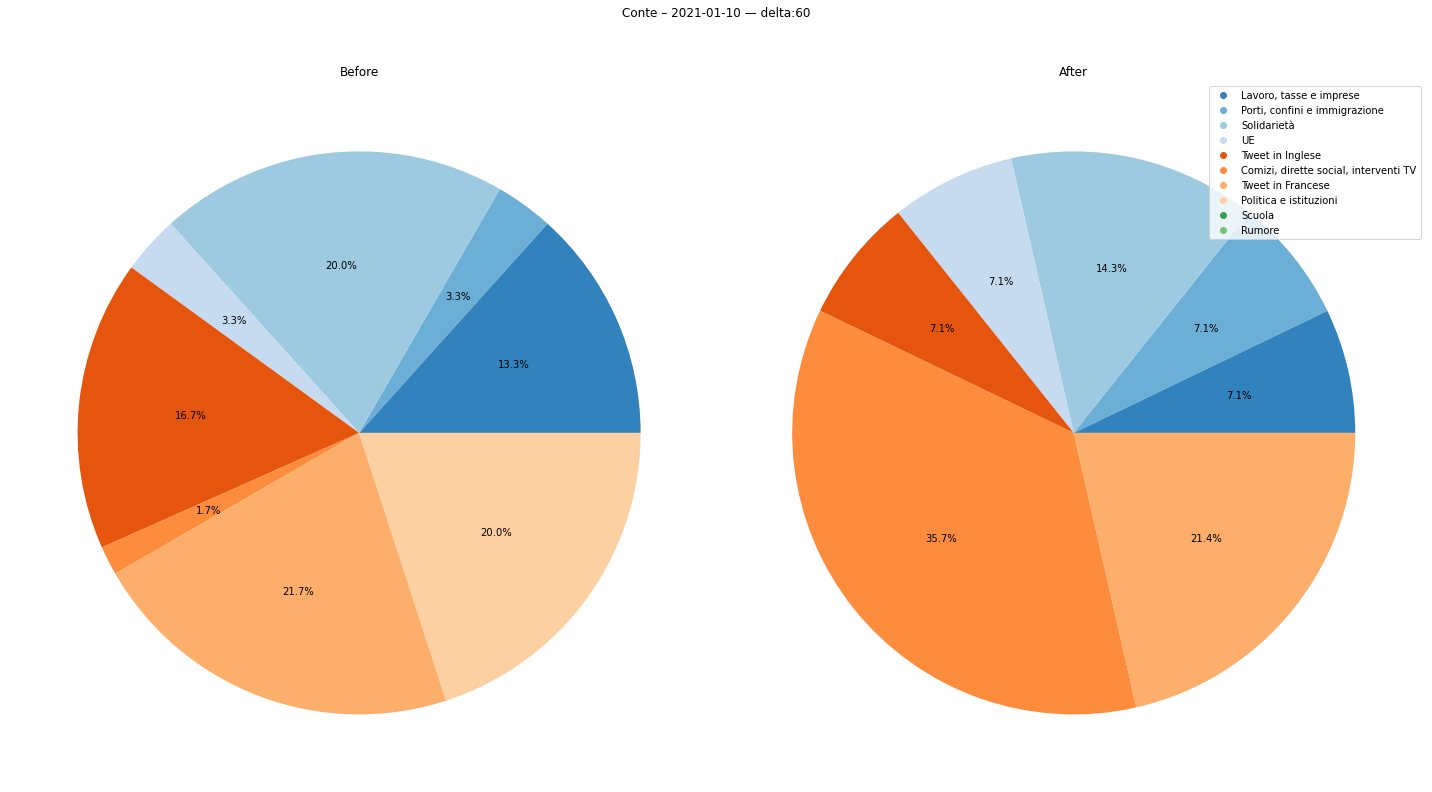

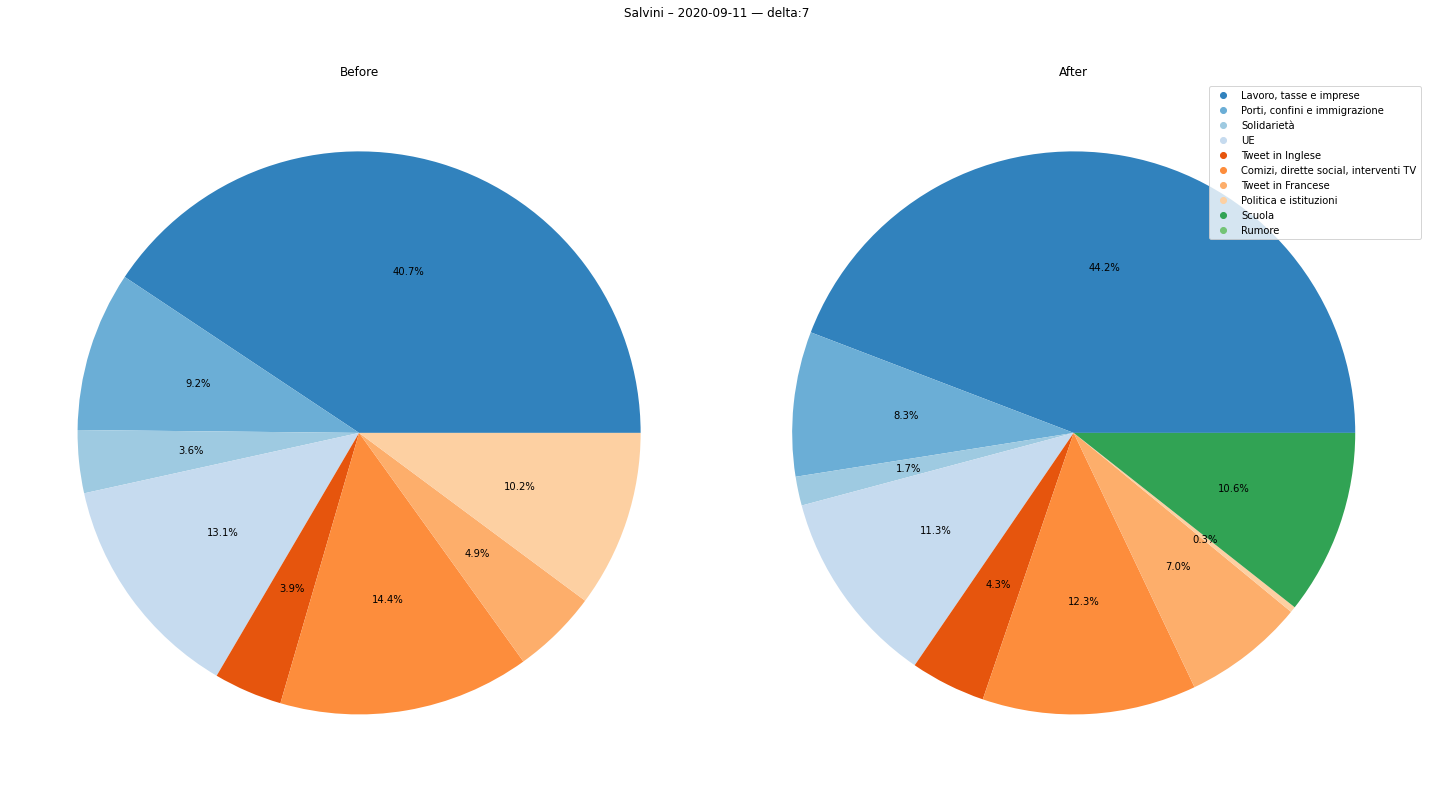

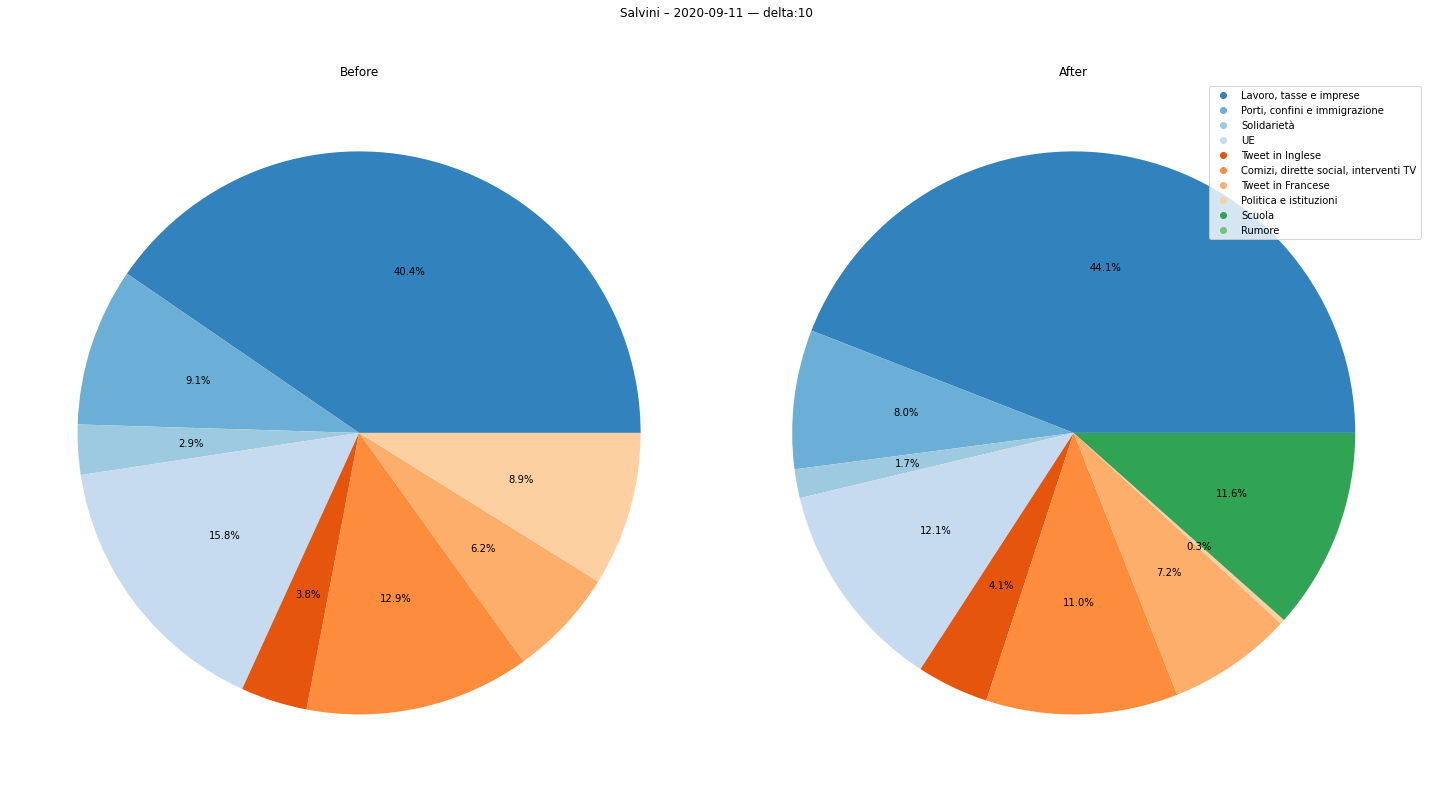

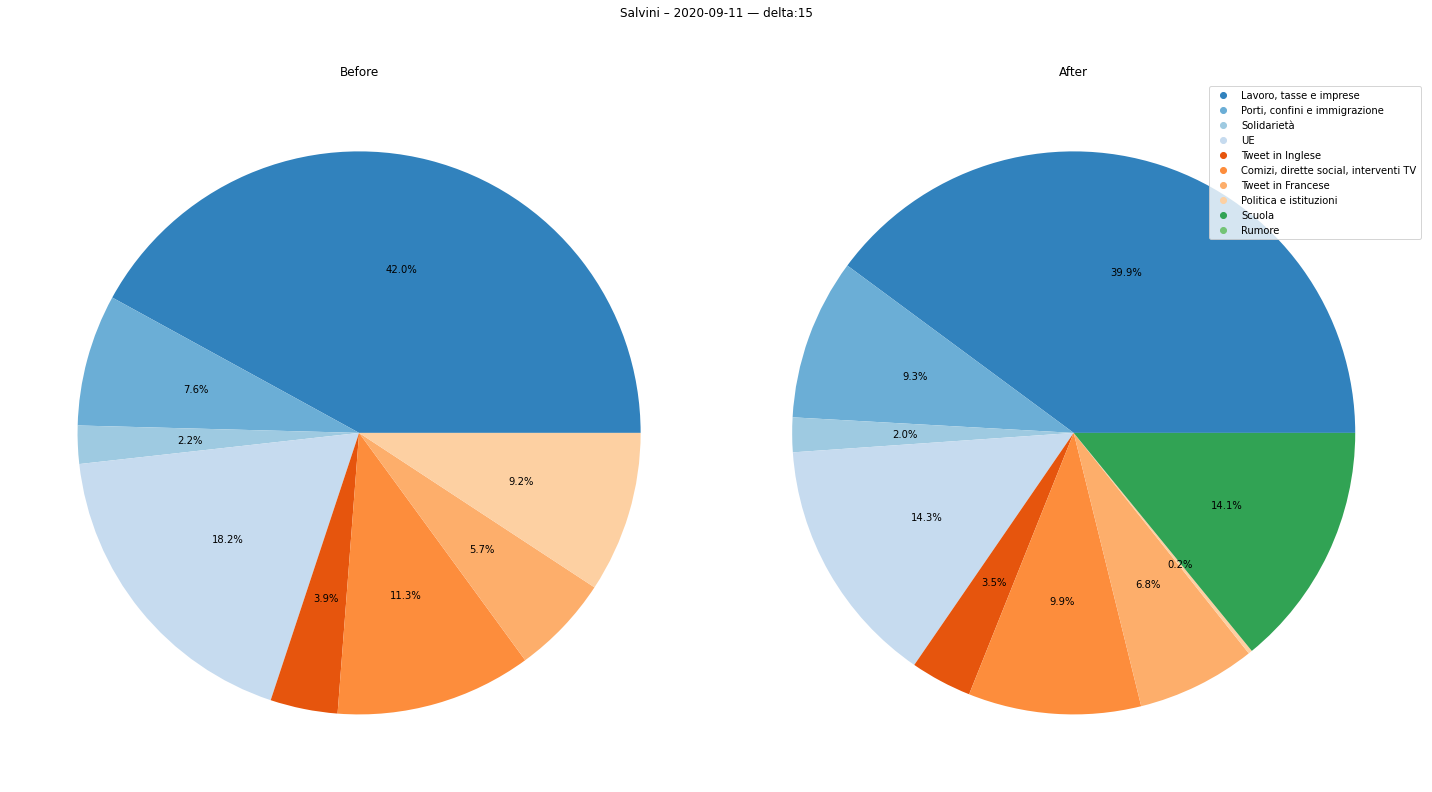

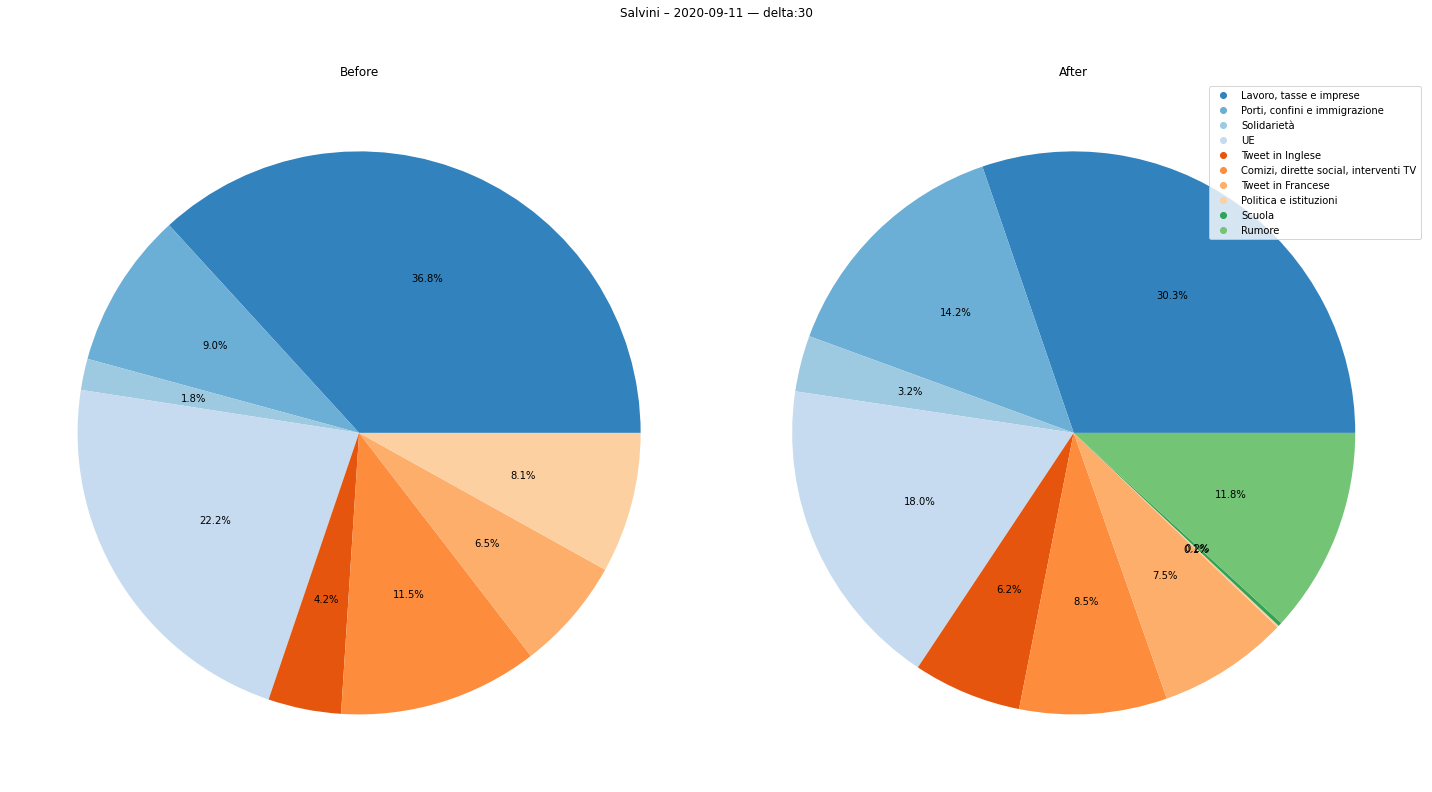

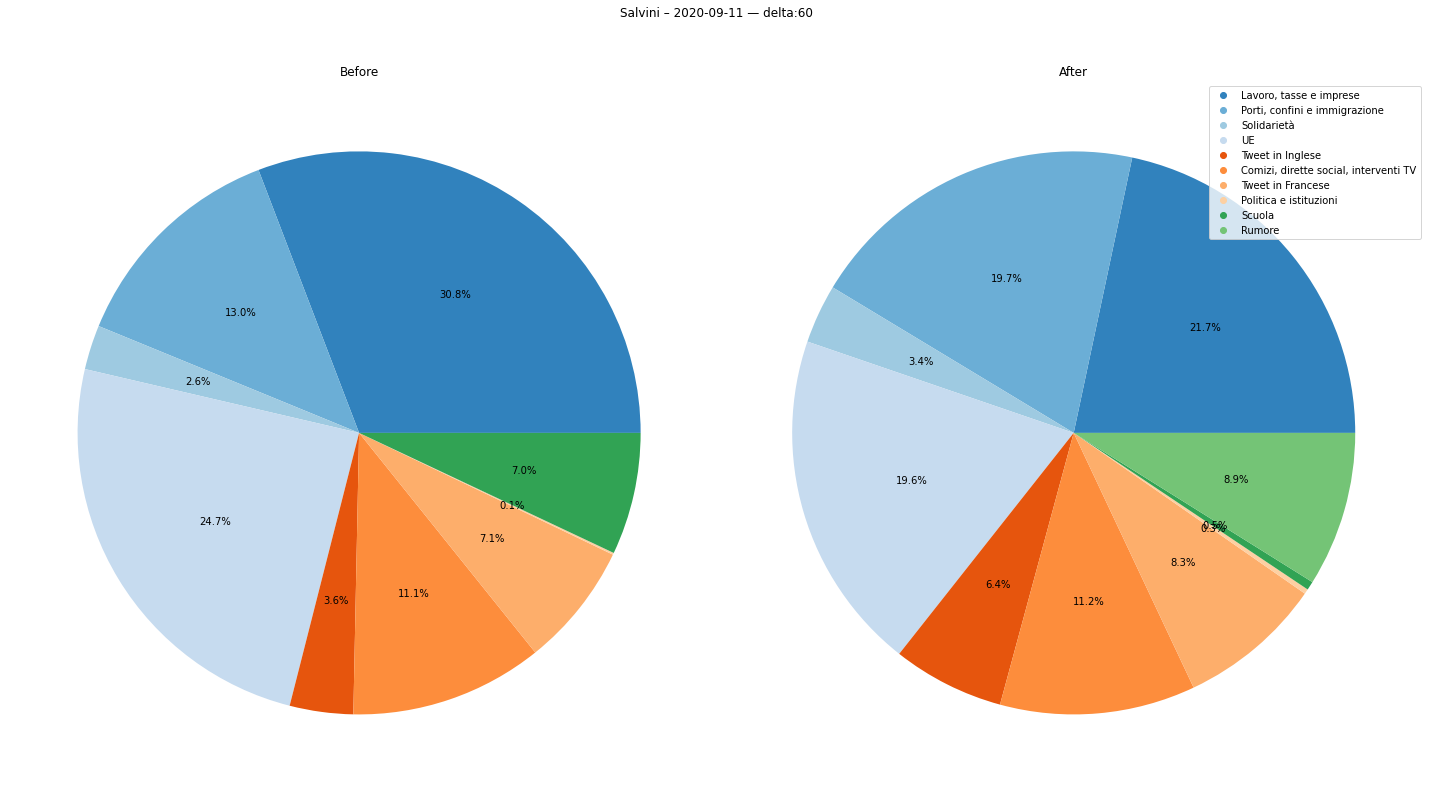

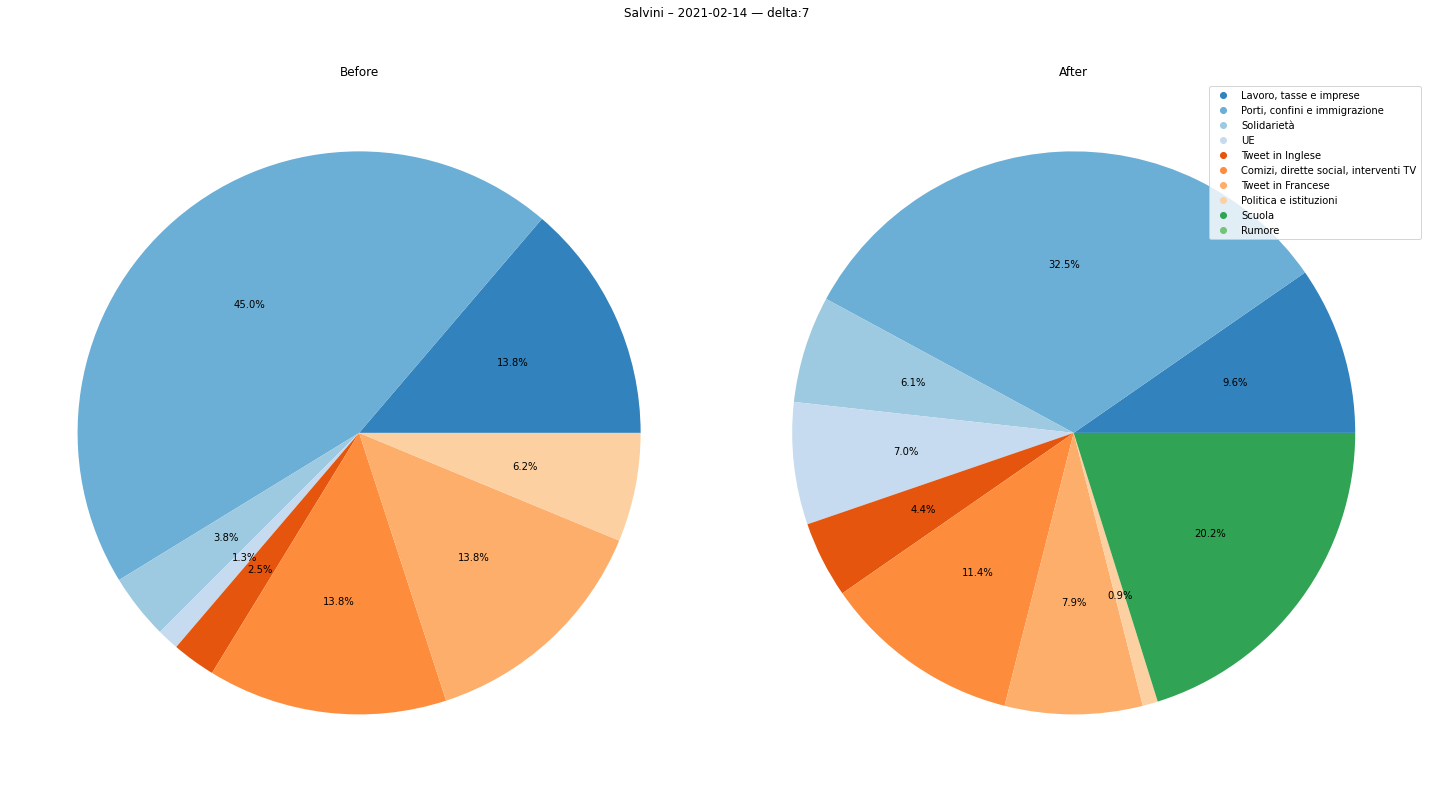

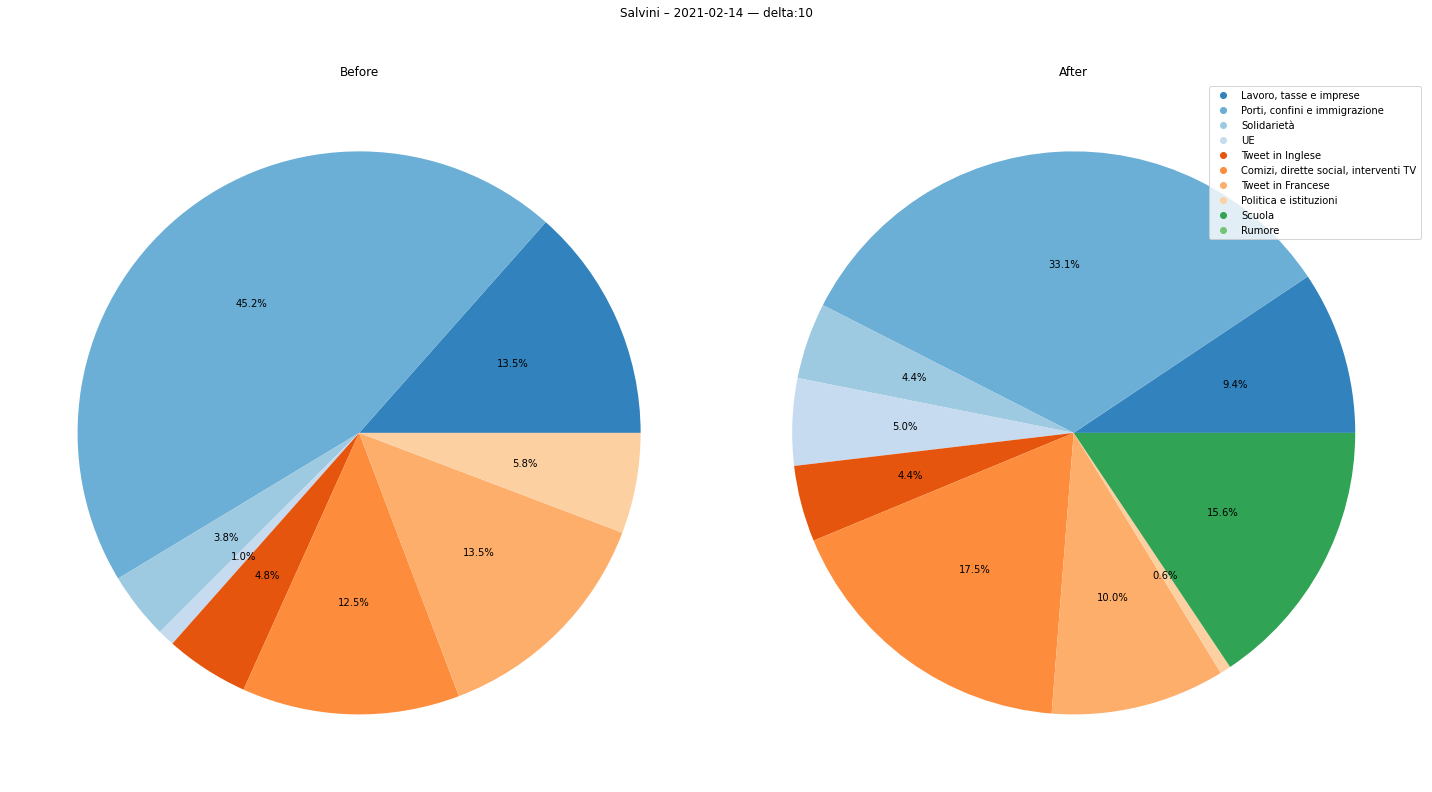

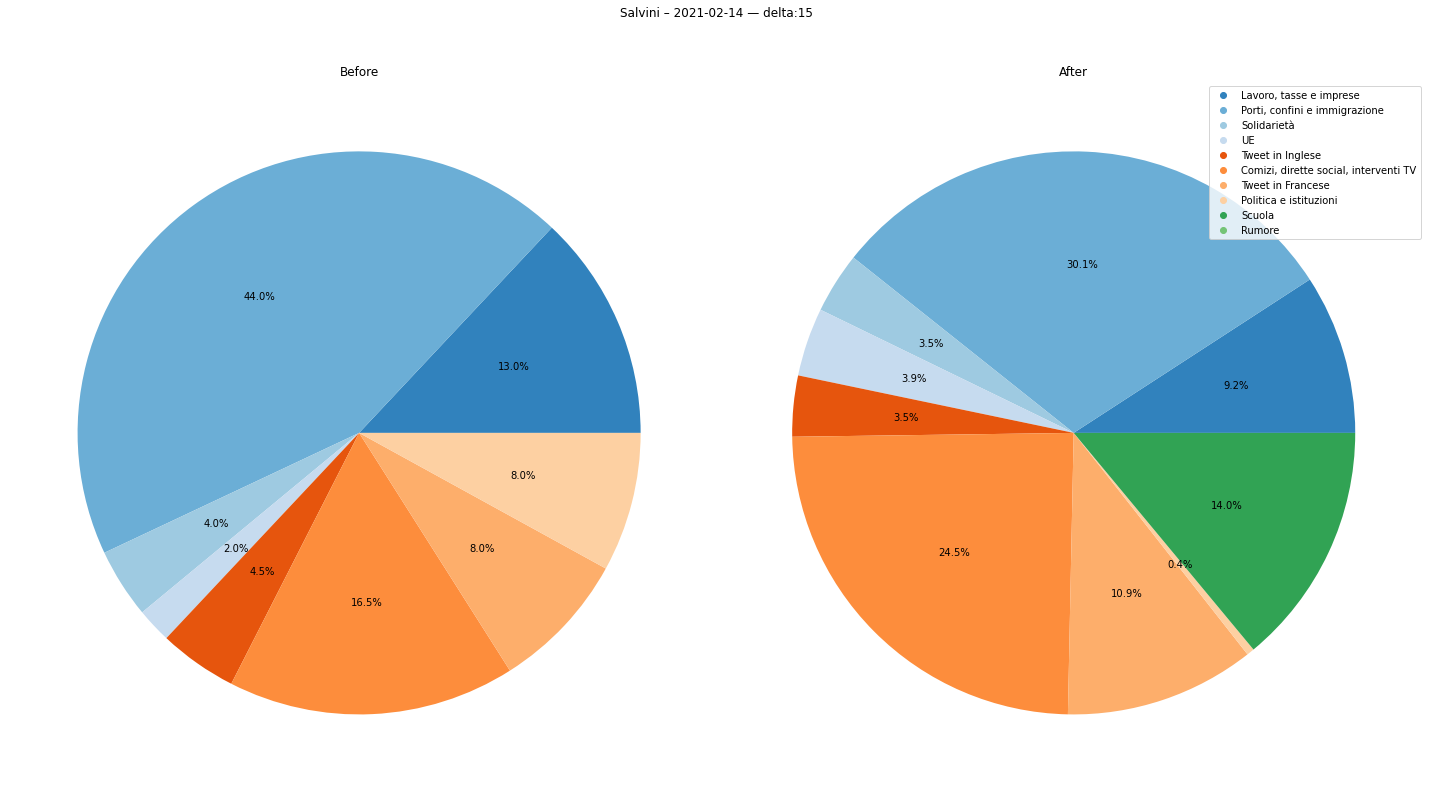

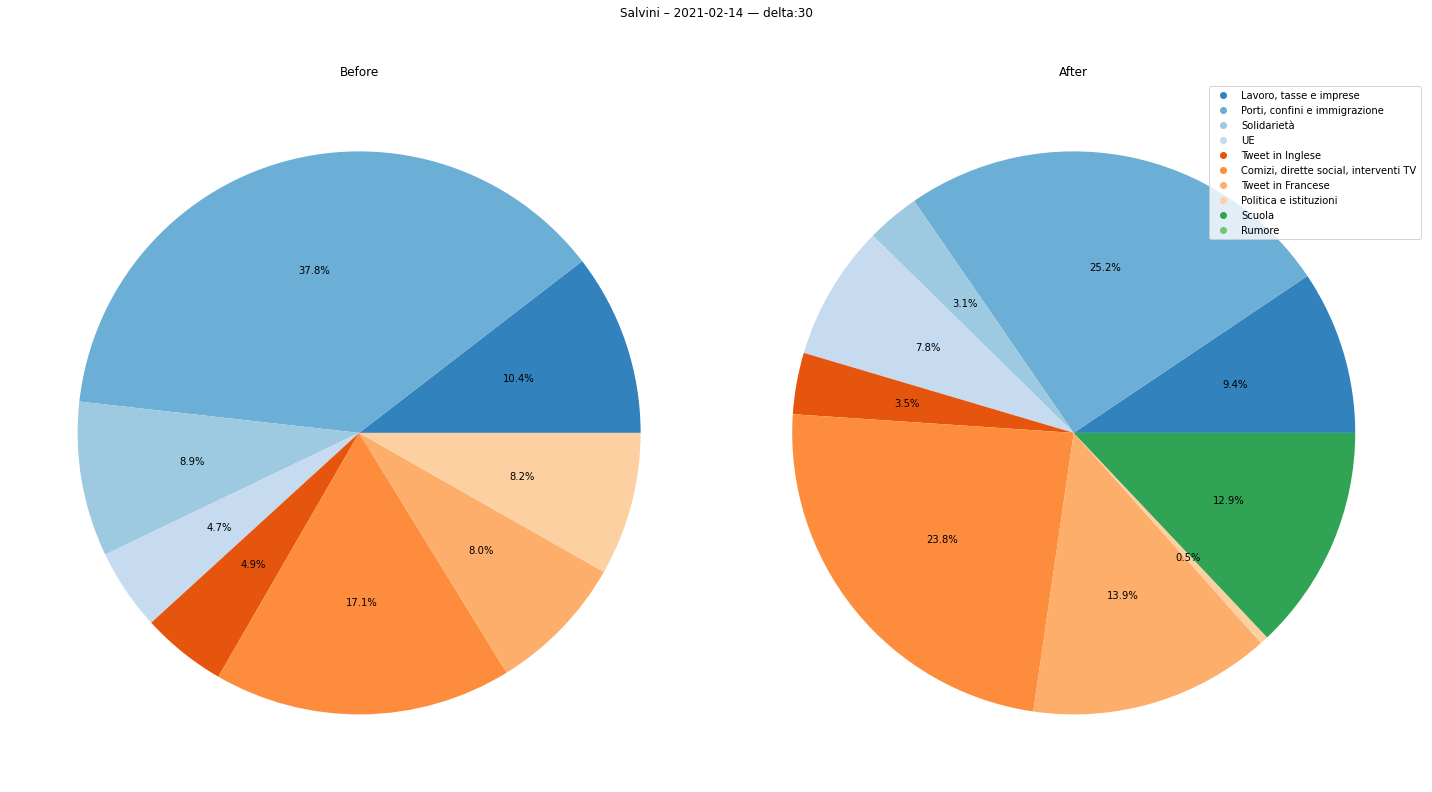

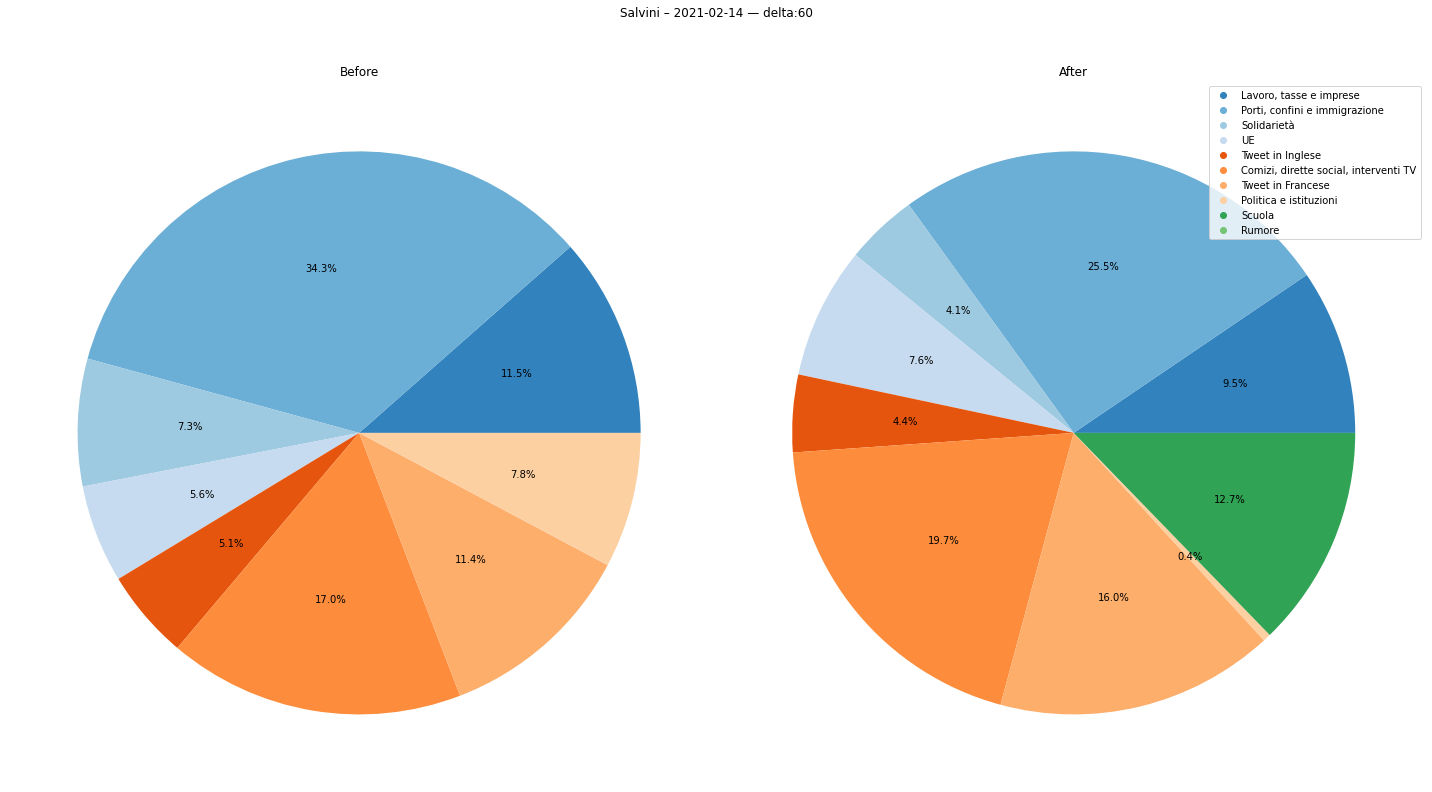

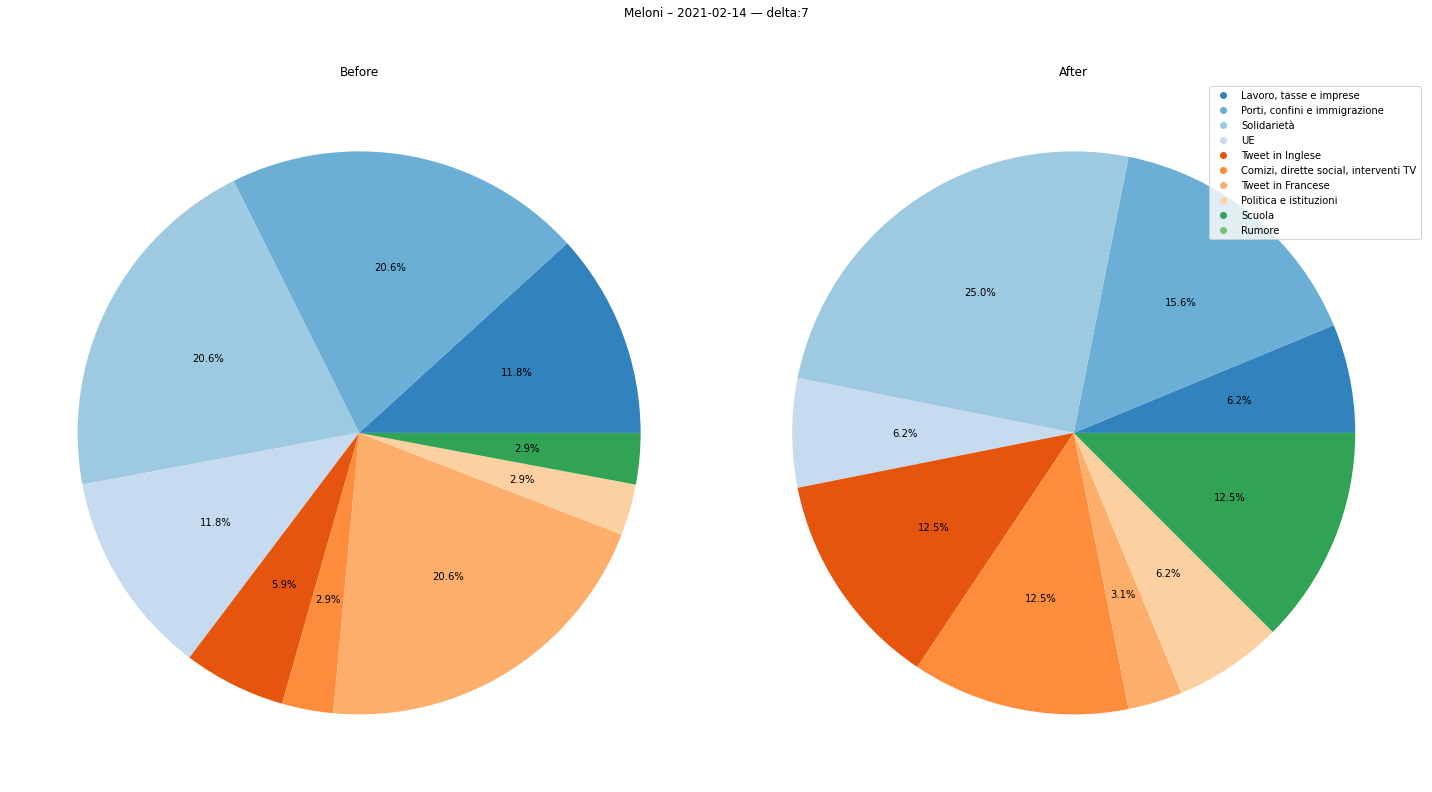

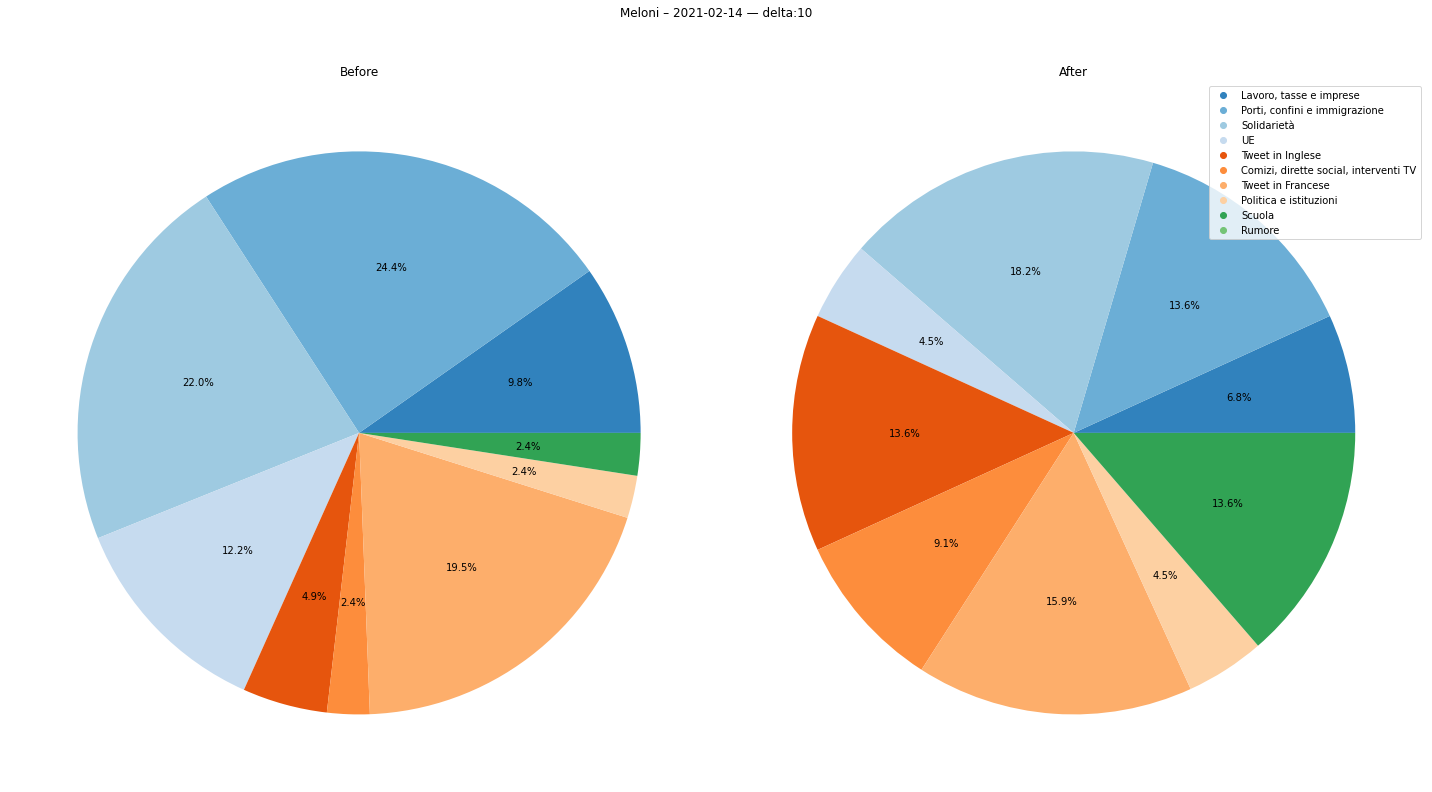

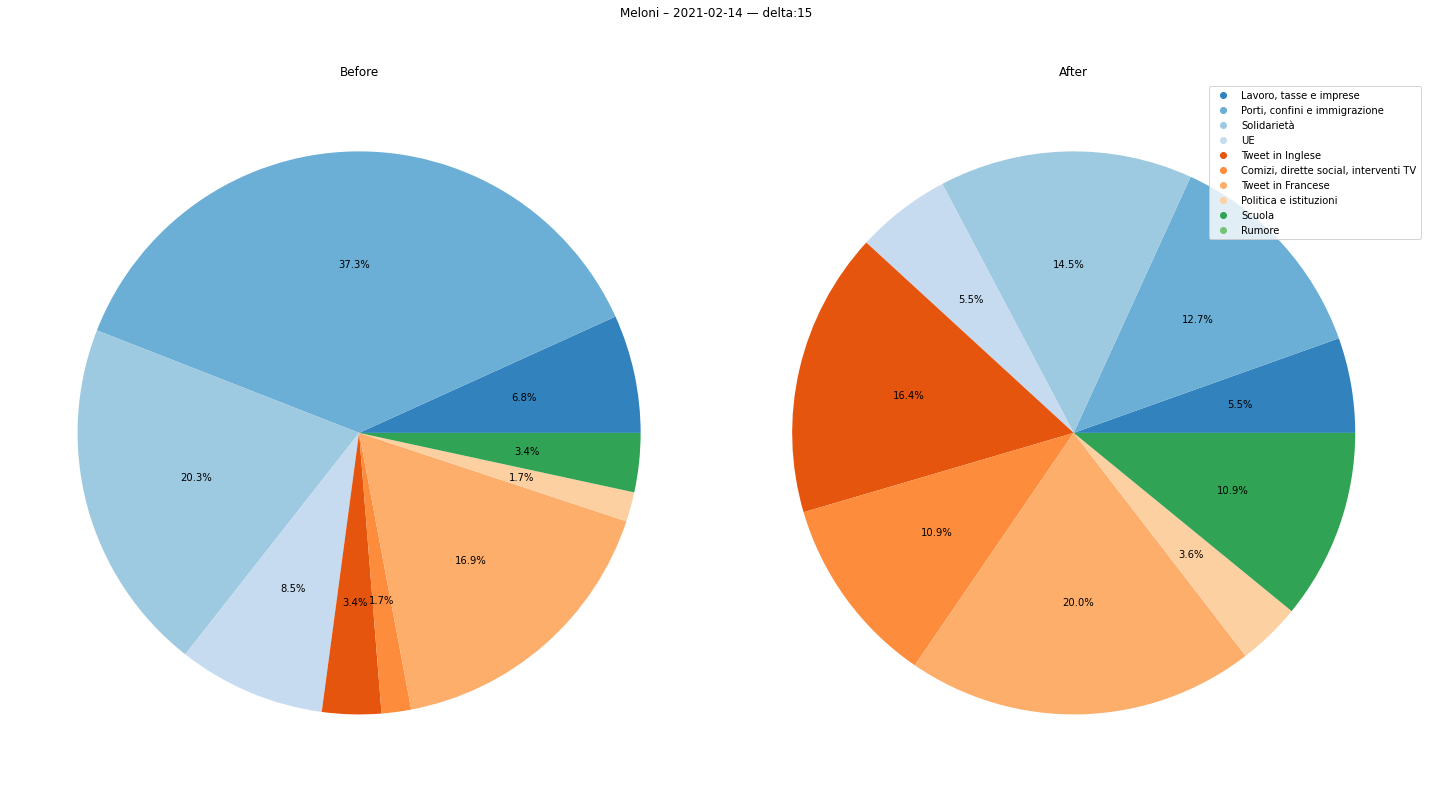

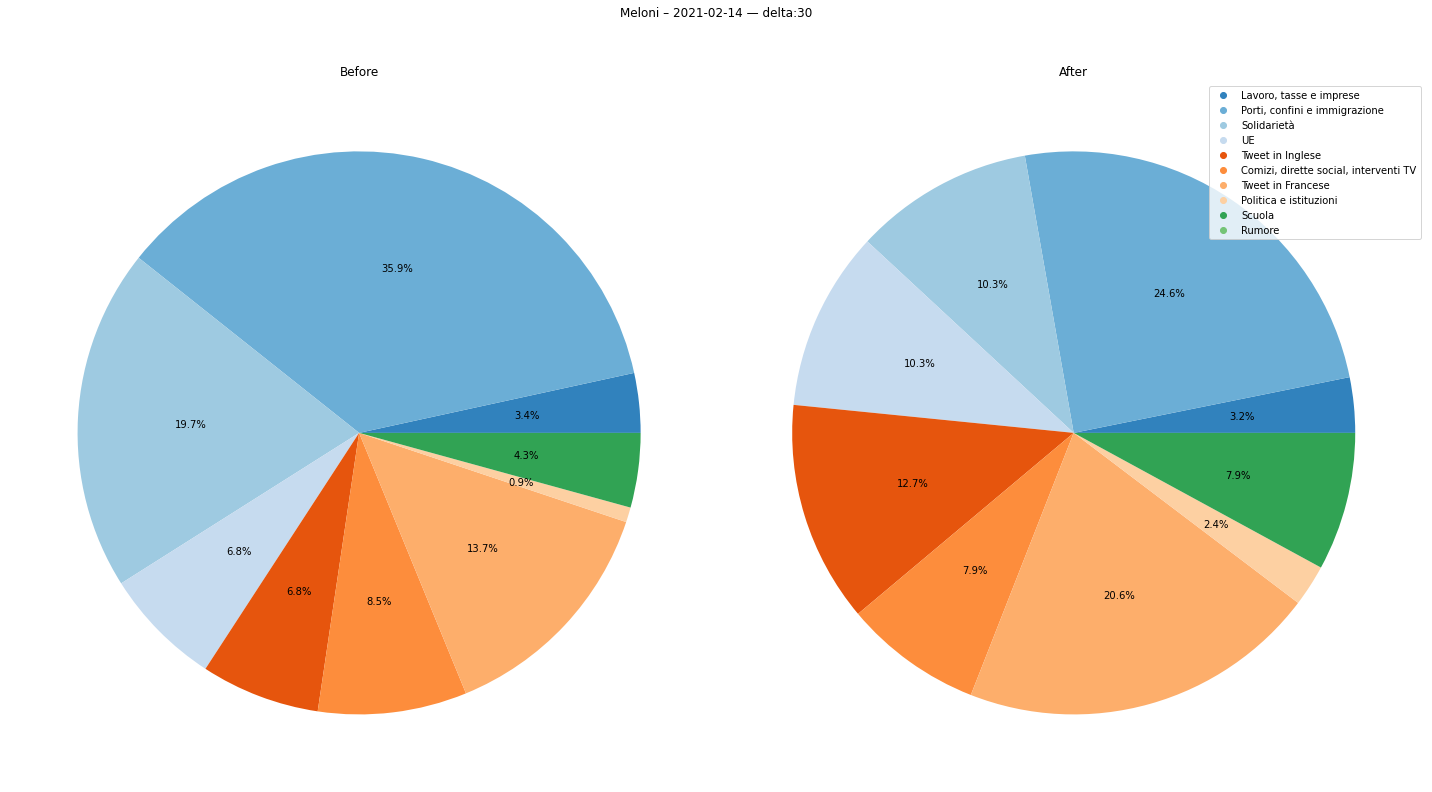

<ipython-input-424-3584d356f73d>:43: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  axs[1].pie(sizes, colors=[colordict[key] for key in labels], autopct='%1.1f%%', pctdistance=0.6)


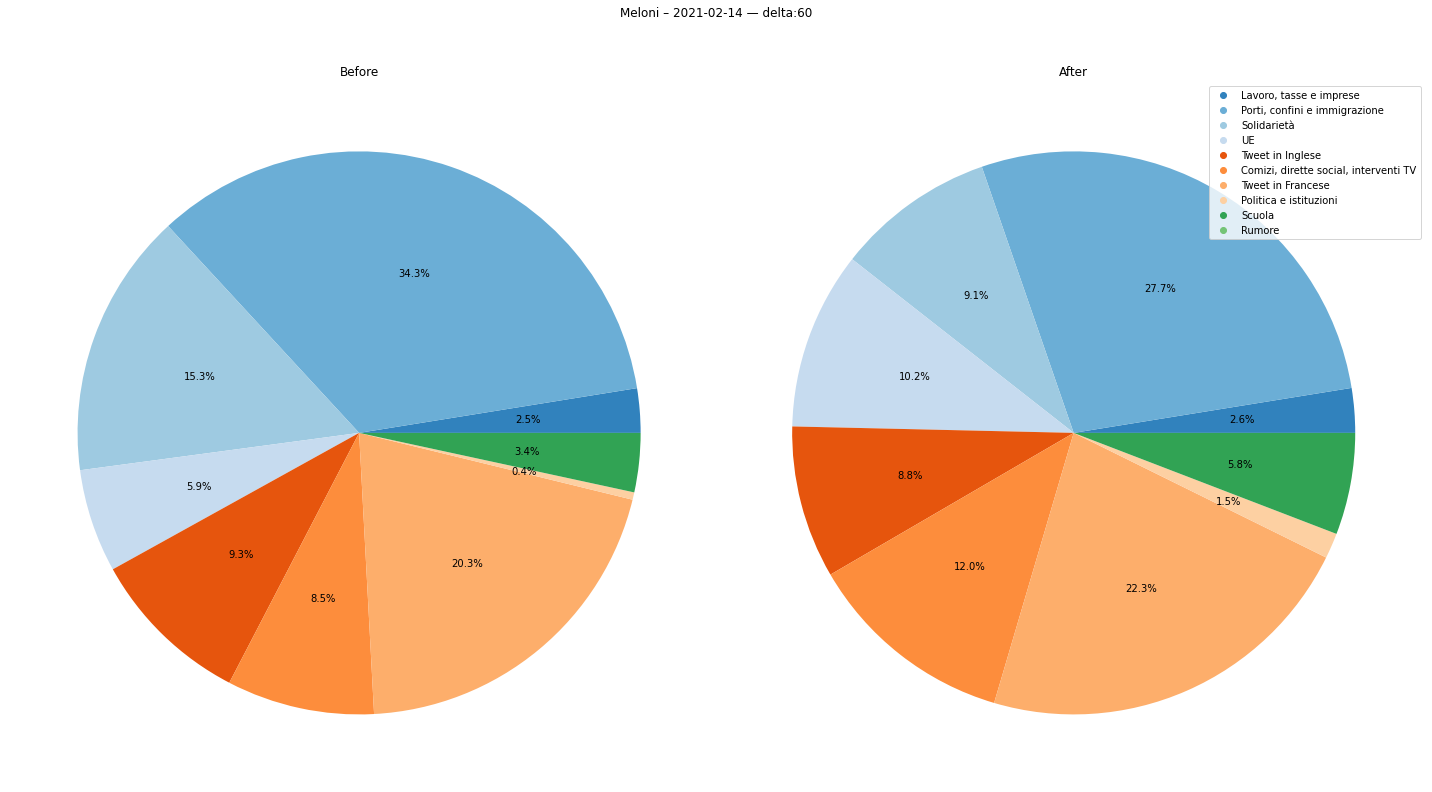

In [425]:
interesting_dates =[
    ('2021-03-14', 'Letta'), 
    ('2021-01-10', 'Conte'), 
    ('2020-09-11', 'Salvini'),
    ('2021-02-14', 'Salvini'), 
    ('2021-02-14', 'Meloni')
]

for tup in interesting_dates:
    for d in [7, 10, 15, 30, 60]:
        chart_with_date(tup[0], tup[1], delta=d)


In [238]:
min(df.Date)

(Timestamp('2020-07-01 09:20:27'), Timestamp('2021-06-30 21:54:58'))